In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_excel("F:\DCS-SEM 4\Predicitive analysis\Dataset\Superstore.xls")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
df.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [4]:
df.shape

(9994, 21)

In [5]:
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

# Variable Analysis

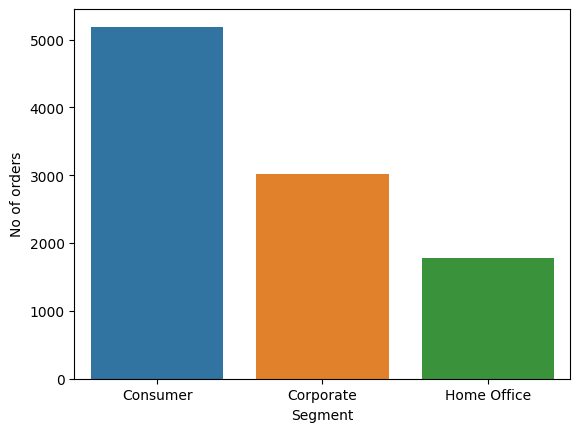

In [6]:
sns.countplot(x='Segment', data=df)
plt.xlabel('Segment')
plt.ylabel('No of orders')
plt.show()

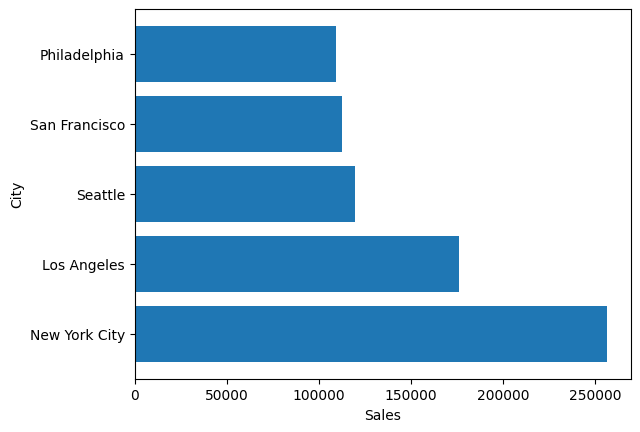

City
New York City    256368.161
Los Angeles      175851.341
Seattle          119540.742
San Francisco    112669.092
Philadelphia     109077.013
Name: Sales, dtype: float64

In [7]:
data = df.groupby('City')['Sales'].sum().sort_values(ascending=False).head(5)
plt.barh(data.index, data.values)
plt.xlabel('Sales')
plt.ylabel('City')
plt.show()

data.head()

In [8]:
from sklearn.preprocessing import LabelEncoder


encoder = LabelEncoder()
for i in df.columns:
    if  df[i].dtype == 'object':
        df[i] = encoder.fit_transform(df[i])

df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,2500,2016-11-08,2016-11-11,2,143,166,0,0,194,...,42420,2,12,0,4,386,261.9600,2,0.00,41.9136
1,2,2500,2016-11-08,2016-11-11,2,143,166,0,0,194,...,42420,2,55,0,5,839,731.9400,3,0.00,219.5820
2,3,2296,2016-06-12,2016-06-16,2,237,201,1,0,266,...,90036,3,946,1,10,1433,14.6200,2,0.00,6.8714
3,4,4372,2015-10-11,2015-10-18,3,705,687,0,0,153,...,33311,2,319,0,16,366,957.5775,5,0.45,-383.0310
4,5,4372,2015-10-11,2015-10-18,3,705,687,0,0,153,...,33311,2,1316,1,14,573,22.3680,2,0.20,2.5164


In [9]:
corr = df.corr()

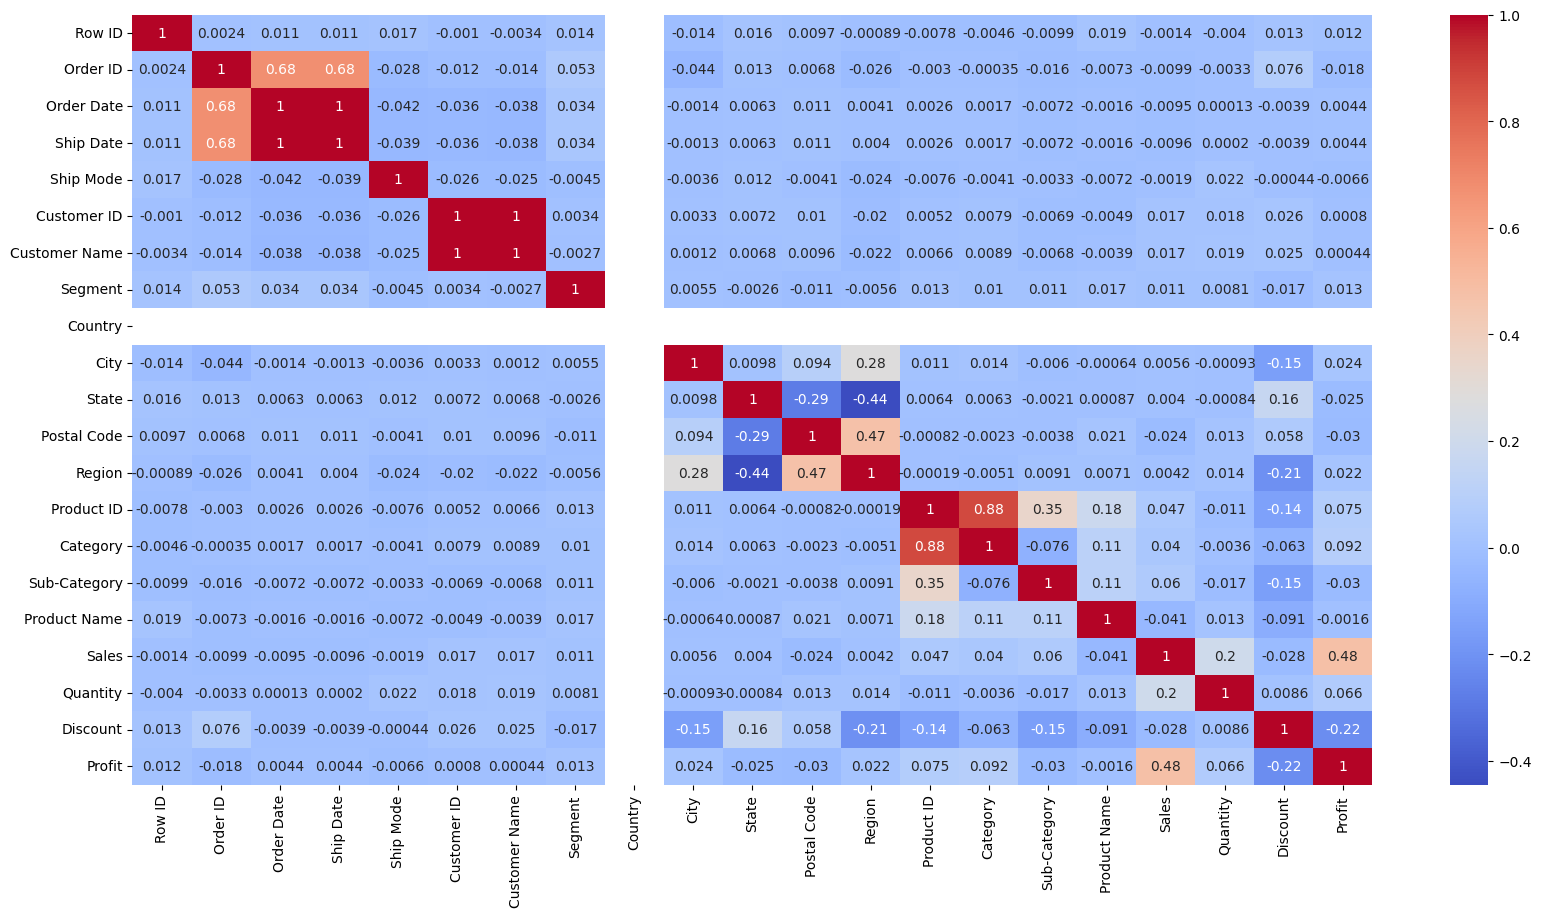

In [10]:
plt.figure(figsize = (20 , 10))
sns.heatmap(corr , annot = True , cmap = 'coolwarm')
plt.show()

#  ARIMA Forecasting

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Data Validation

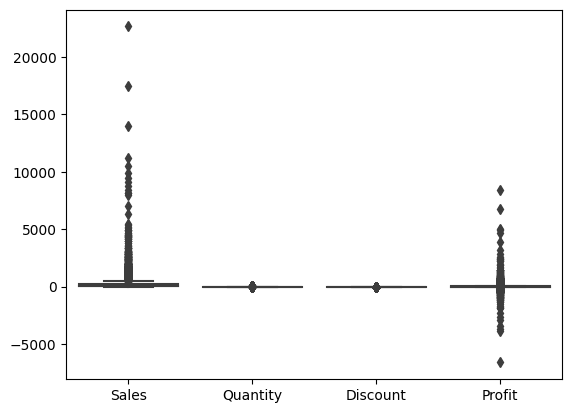

In [12]:
sns.boxplot(df[["Sales", "Quantity", "Discount", "Profit"]])
plt.show()

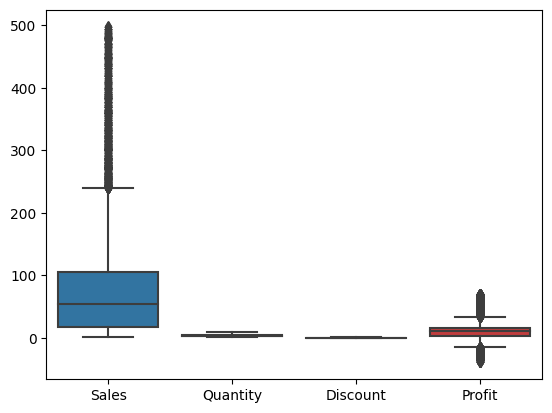

In [13]:
train = df[["Sales", "Quantity", "Discount", "Profit"]]
def impute_outliers(data, column, factor):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    
    data_copy = data.copy()
    data_copy[column] = np.where(data_copy[column] < lower_bound, np.nan, data_copy[column])
    data_copy[column] = np.where(data_copy[column] > upper_bound, np.nan, data_copy[column])
    
    imputer = SimpleImputer(strategy="mean")
    data_imputed = imputer.fit_transform(data_copy)
    
    return pd.DataFrame(data_imputed, columns=data.columns)

for column in ["Sales", "Quantity", "Discount", "Profit"]:
    train = impute_outliers(train, column, 1.5)

df[["Sales", "Quantity", "Discount", "Profit"]] = train
sns.boxplot(train)
plt.show()

In [14]:
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Ship Date"] = pd.to_datetime(df["Ship Date"])

df["Order Month"] = df["Order Date"].dt.month
df["Order Year"] = df["Order Date"].dt.year
# Aggregate the sales by month
sales_by_year = df.groupby("Order Year")["Sales"].sum().reset_index()
sales_by_year.head()

,Order Year,Sales
0,2014,182021.812998
1,2015,197026.767878
2,2016,243166.689162
3,2017,305876.068544


### Model Fitting and evaluation

In [15]:
arima_model = ARIMA(sales_by_year["Sales"], order=(1, 1, 1))
arima_model_fit = arima_model.fit()
y_true = sales_by_year["Sales"]
y_pred = arima_model_fit.fittedvalues
print("MAE:", mean_absolute_error(y_true, y_pred))
print("MSE:", mean_squared_error(y_true, y_pred))

MAE: 60789.76056175548
MSE: 8631551789.009312


d:\Python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Forecasting

In [16]:
forecast = arima_model_fit.forecast(steps = 5)
print(forecast)

4    346570.325315
5    387262.744065
6    427953.324878
7    468642.067837
8    509328.973025
Name: predicted_mean, dtype: float64


### Plotting of Actual data with Forecasted data

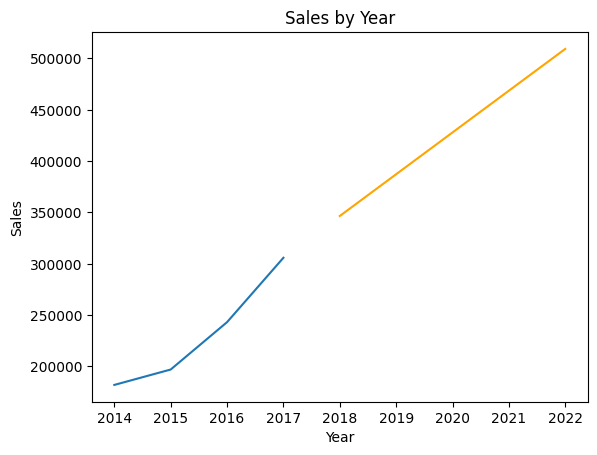

In [17]:
plt.plot(sales_by_year["Order Year"], sales_by_year["Sales"])
plt.plot([2018 , 2019 , 2020 , 2021 , 2022],forecast, color = "orange")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.title("Sales by Year")
plt.show()

# Forecasting for each Category

In [18]:
x = df.groupby([ 'Category' , 'Order Year'])['Sales'].sum().reset_index().pivot(index = 'Order Year' , 
                                                                                columns = 'Category' , values = "Sales")
x.head()

Category,0,1,2
Order Year,,,
2014,55277.269199,75107.949608,51636.594191
2015,63547.688730,75396.882872,58082.196277
2016,78848.486455,96011.671958,68306.530749
2017,93572.140260,124767.955394,87535.972891


d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index

d:\Python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq

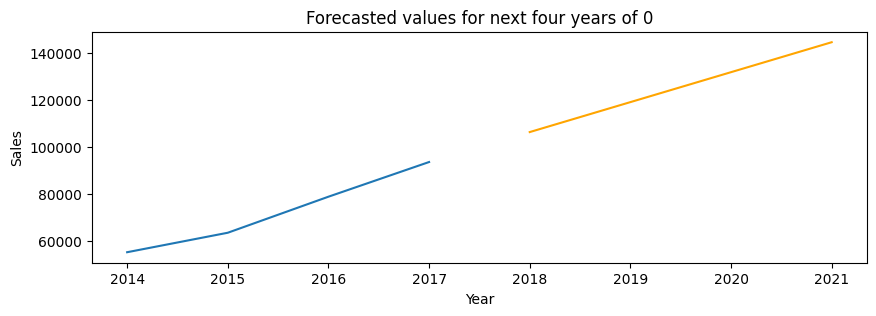

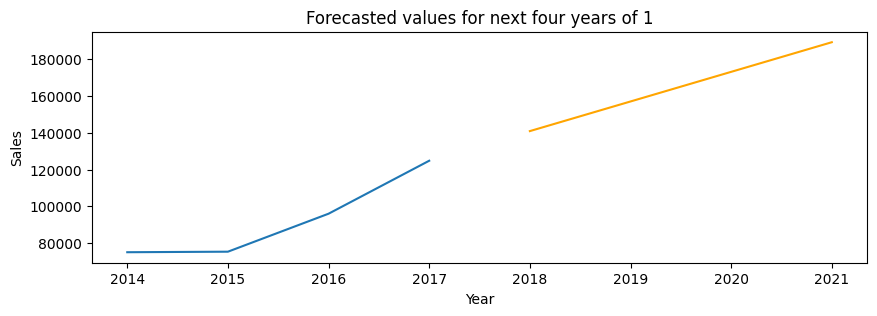

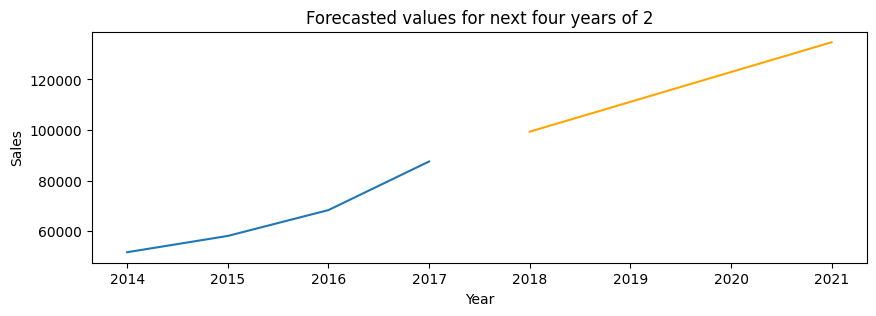

In [19]:
def forecasting(x):
    arima_model = ARIMA(x , order = (1,1,1))
    arima_model_fit= arima_model.fit()
    forecast_values = arima_model_fit.forecast(steps = 4)
    return forecast_values.round(2)

for i in x.columns:
    values = forecasting(x[i])
    plt.figure(figsize = (10, 3))
    plt.plot(x.index,x[i])
    plt.plot([2018 , 2019 , 2020 , 2021] , values , color = 'orange')
    plt.xlabel('Year')
    plt.ylabel('Sales')
    plt.title(f'Forecasted values for next four years of {i}')
    

# Clustering

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [21]:
df_cluster = df[["Customer ID","Sales", "Quantity", "Discount", "Profit"]].groupby("Customer ID").sum()
train = df_cluster[["Sales", "Quantity", "Discount", "Profit"]]

## Optimal K size
### Elbow Method

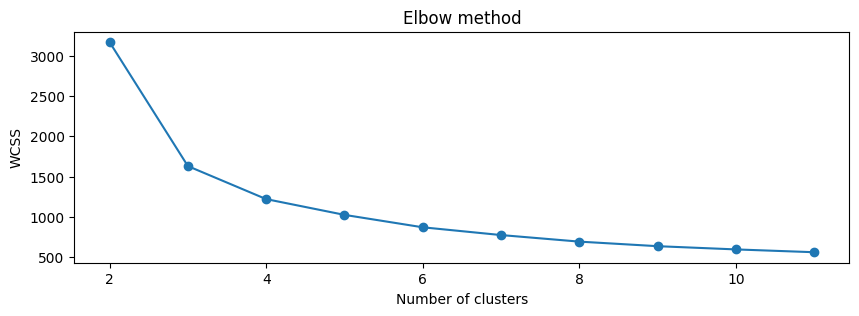

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train)

#Elbow Method
wcss = [] 
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42 , n_init = 10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize = (10 ,3))
plt.plot(range(2, 12), wcss, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.title("Elbow method")
plt.show()

### Infrence
We can see that from 2 - 3 the value of WCSS decreasing fast and in a straight but after 2 there is a slow drop and decreasing exponentially so K = 3

## K - Means Algorithim

In [23]:
k_opt = 3 
kmeans_opt = KMeans(n_clusters=k_opt, random_state=42 , n_init = 10)
kmeans_opt.fit(train)

# Assign the cluster labels to the data set
df_cluster["Cluster"] = kmeans_opt.labels_

In [24]:
df_cluster[["Sales", "Quantity", "Discount", "Profit" , "Cluster"]].groupby("Cluster").sum(numeric_only = True)

,Sales,Quantity,Discount,Profit
Cluster,,,,
0,318441.762800,10502.003257,297.529169,35264.503837
1,178599.040262,9146.156352,264.010578,26565.074308
2,431050.535521,16869.004886,472.737541,54141.657193


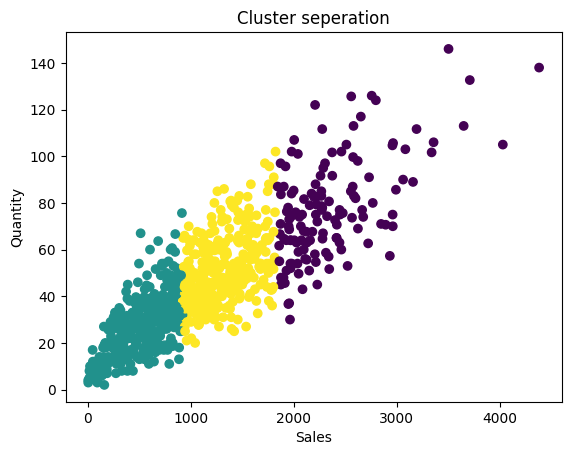

In [25]:
plt.scatter(df_cluster['Sales'] , df_cluster['Quantity'] , c = df_cluster['Cluster'])
plt.xlabel('Sales')
plt.ylabel('Quantity')
plt.title('Cluster seperation')
plt.show()

### Infrence
* Cluster 0 has an average sales value of 130534.24, an average quantity of 9534.16, an average discount of 277.17 and an average profit of 21244.03.
* Cluster 1 has an average sales value of 155063.45, an average quantity of 9148.77, an average discount of 247.36 and an average profit of 21353.37.
* Cluster 2 has an average sales value of 281272.53, an average quantity of 17834.24, an average discount of 509.75 and an average profit of 40649.32.

### Conclusion
Based on these values, Cluster 2 has the highest mean values for sales, quantity, discount and profit. This suggests that customers in Cluster 2 are generating more sales and profit for the supermarket compared to customers in Clusters 0 and 1.

Overall, this analysis suggests that customers in Cluster 2 may be more valuable to the supermarket in terms of generating sales and profit. It may be worth exploring further to understand what differentiates customers in Cluster 2 from those in Clusters 0 and 1 and how the supermarket can attract more customers like those in Cluster 2.


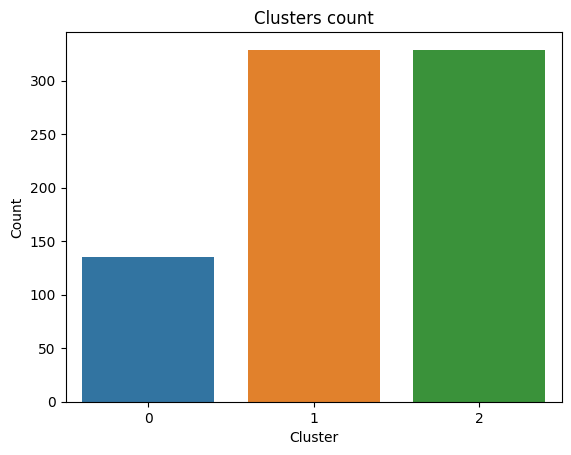

In [26]:
sns.countplot(x = 'Cluster' , data = df_cluster)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Clusters count')
plt.show()

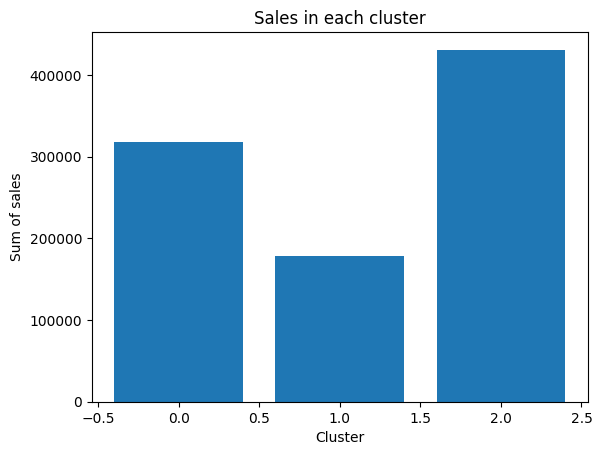

In [27]:
temp = df_cluster[['Sales' , 'Cluster']].groupby('Cluster').sum()
plt.bar(temp.index, temp['Sales'])
plt.title('Sales in each cluster')
plt.xlabel('Cluster')
plt.ylabel('Sum of sales')
plt.show()

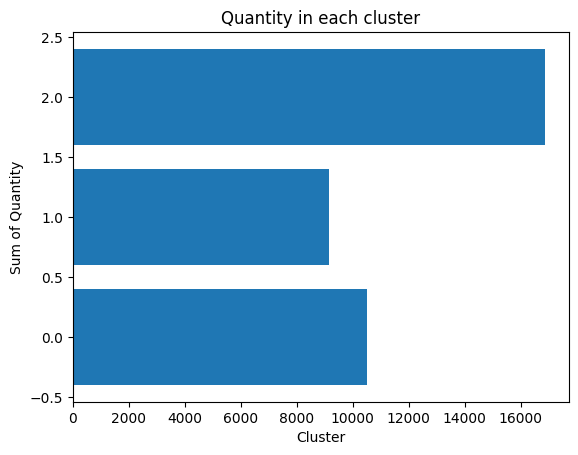

In [28]:
temp = df_cluster[['Quantity' , 'Cluster']].groupby('Cluster').sum()
plt.barh(temp.index, temp['Quantity'])
plt.title('Quantity in each cluster')
plt.xlabel('Cluster')
plt.ylabel('Sum of Quantity')
plt.show()

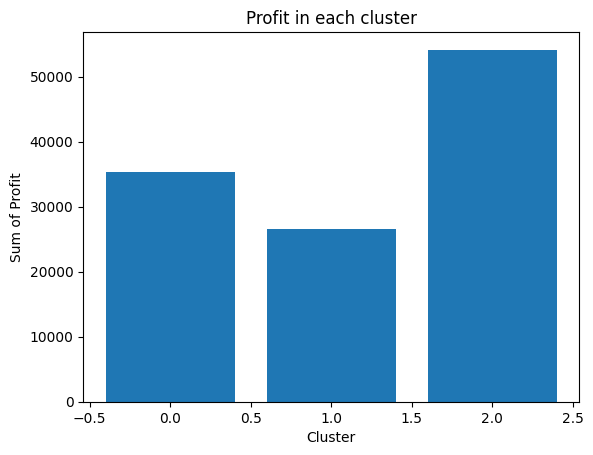

In [29]:
temp = df_cluster[['Profit' , 'Cluster']].groupby('Cluster').sum()
plt.bar(temp.index, temp['Profit'])
plt.title('Profit in each cluster')
plt.xlabel('Cluster')
plt.ylabel('Sum of Profit')
plt.show()

In [30]:
df_cluster0 = df_cluster.where(df_cluster['Cluster'] == 0).dropna()
df_cluster1 = df_cluster.where(df_cluster['Cluster'] == 1).dropna()
df_cluster2 = df_cluster.where(df_cluster['Cluster'] == 2).dropna()

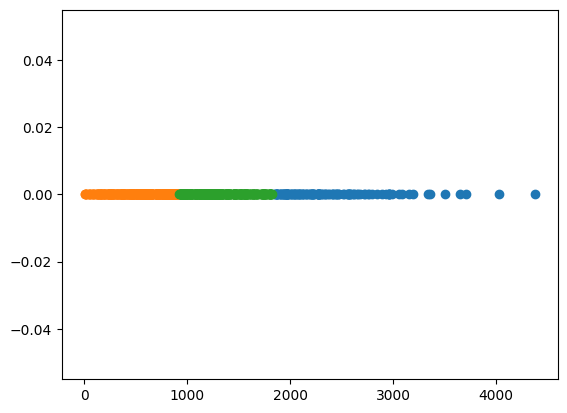

In [31]:
plt.plot(df_cluster0['Sales'] , np.zeros_like(df_cluster0['Sales']) , 'o')
plt.plot(df_cluster1['Sales'] , np.zeros_like(df_cluster1['Sales']) , 'o')
plt.plot(df_cluster2['Sales'] , np.zeros_like(df_cluster2['Sales']) , 'o')
plt.show()

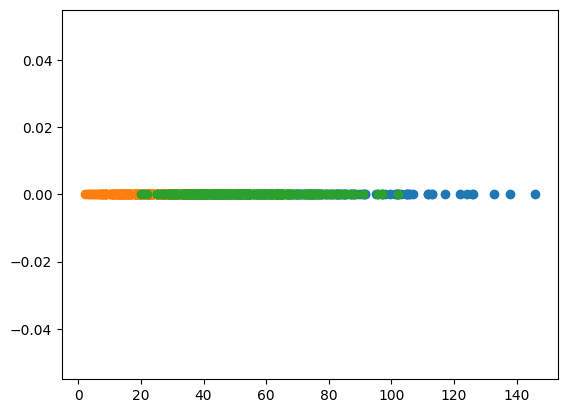

In [32]:
plt.plot(df_cluster0['Quantity'] , np.zeros_like(df_cluster0['Quantity']) , 'o')
plt.plot(df_cluster1['Quantity'] , np.zeros_like(df_cluster1['Quantity']) , 'o')
plt.plot(df_cluster2['Quantity'] , np.zeros_like(df_cluster2['Quantity']) , 'o')
plt.show()

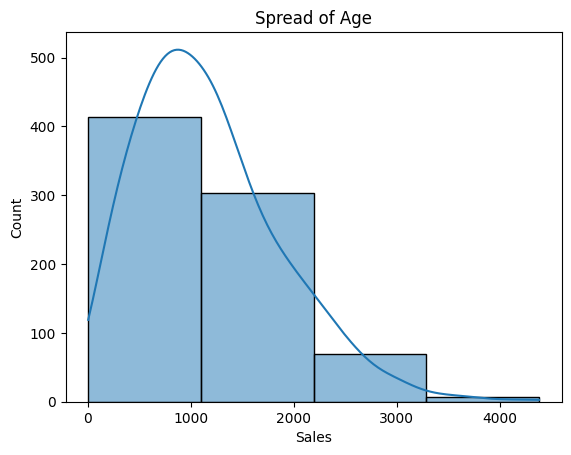

In [33]:
sns.histplot(df_cluster['Sales'] , kde = True , bins = 4)
plt.title('Spread of Age')
plt.show()

<Figure size 3000x3000 with 0 Axes>

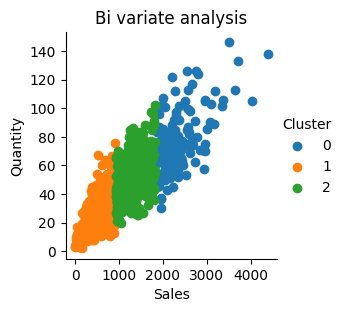

In [34]:
plt.figure(figsize = (30 , 30))
sns.FacetGrid(df_cluster, hue = "Cluster").map(plt.scatter , "Sales" , "Quantity" ).add_legend();
plt.title('Bi variate analysis')
plt.show()

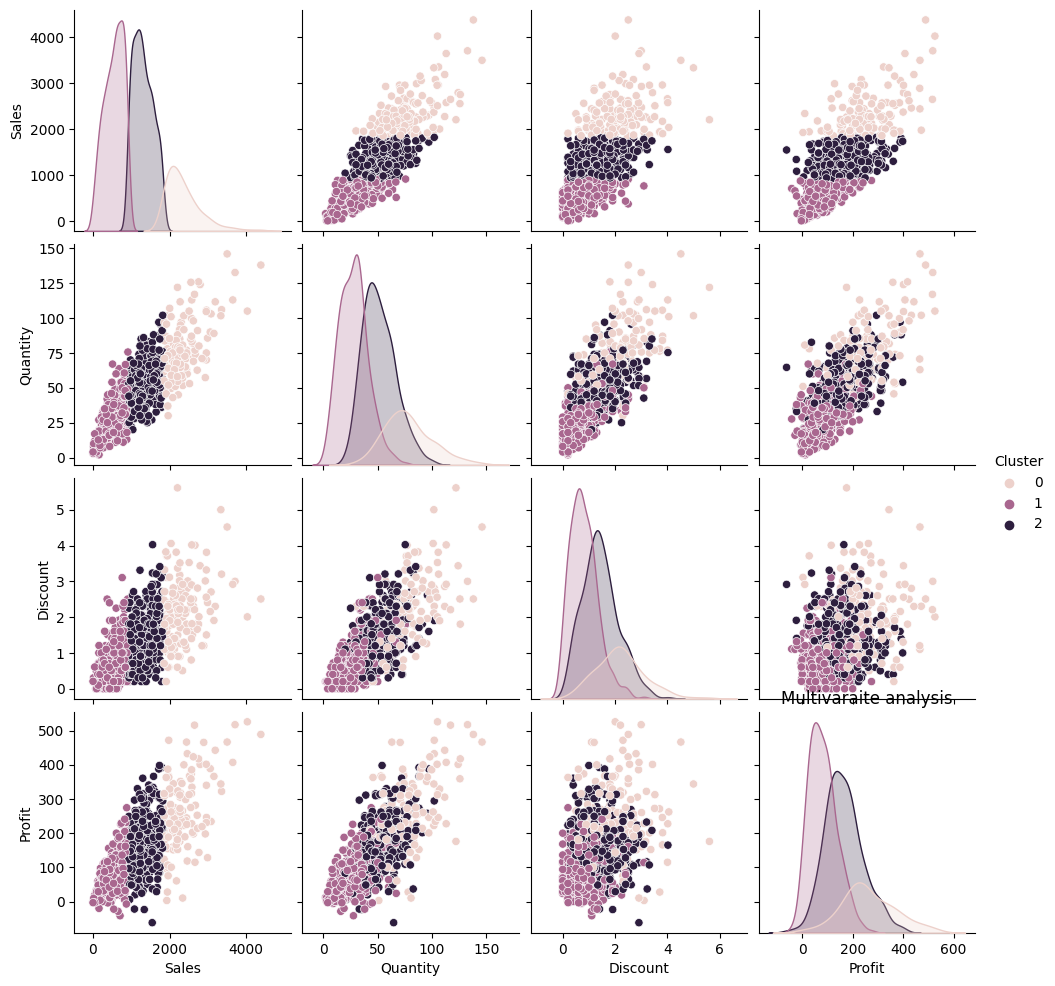

In [35]:
sns.pairplot(df_cluster , hue = 'Cluster')
plt.title('Multivaraite analysis')
plt.show()

# Classification

In [36]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

## Fitting and Evaluation 

In [41]:
X = df_cluster[["Sales" ,  "Quantity", "Discount", "Profit"]]
y = df_cluster["Cluster"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
model = SVC(kernel = 'linear')
model.fit(X_train, y_train)

#Predictions
y_pred = model.predict(X_test)

#Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[28  0  0]
 [ 0 61  1]
 [ 0  0 69]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      0.98      0.99        62
           2       0.99      1.00      0.99        69

    accuracy                           0.99       159
   macro avg       1.00      0.99      0.99       159
weighted avg       0.99      0.99      0.99       159



## Classifiying new rows

In [43]:
def predict(test):
    return model.predict(test)

name          = input('Name:')
sales         = int(input("Sales:"))
quantity      = int(input("Quantity:"))
discount_rate = float(input("Discount:"))
profit        = int(input("Profit:"))

cluster = predict(pd.DataFrame({'Sales' :[sales], 'Quantity' :[quantity] , 'Discount' : [discount_rate] , 'Profit':[profit]}))
print(f'Cusomer {name} belongs to cluster :{cluster[0]}')

Cusomer Kaviya belongs to cluster :1
